## Finding:
## 1.
## Test Date 4/23/2017 - 5/31/2017
## Train Date 1/1/2016 - 4/22/2017
## Air Reserve Date 1/1/2016 - 5/31/2017
## Hpg Reserve Date 1/1/2016 - 5/31/2017

## 2.
## Air Reserve has 314 stores
## Hpg Reserve has 13325 stores
## Train Data have 829 stores
## Test Data have 821 stores
## 150 stores have both Air and Hpg

## 3.
## Day_of_week and Month matters

## Friday, Holiday eve matters ?

## 4.
## Try Lag, start with 7

## 5.
## Some reserve data are weird:
## - air_store_id = 'air_e7fbee4e3cfe65c5' and visit_date = '2017-02-05' has lots of reservation nearly half year ago with total reserve visitors = 1663, way more than the real # of visitors

## 6.
## Even among those with reservations, the relation between total number of visitors and total number of reservation visitors seems to be quite weak.

## 7. Area and genre can start with regular label encoding, then mean encoding.

In [1]:
import os
import numpy as np
import pandas as pd
import platform
import pickle
from pathlib import Path
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%qtconsole

In [3]:
if platform.system() == 'Linux':
    data_dir = '/home/alin/Data/Recruit_Holding'
else:
    data_dir = 'C:/Users/alin/Documents/Data/Recruit_Holding'

In [69]:
DFS_dump = data_dir + '/DFS.p'
if Path(DFS_dump).is_file():
    print('load previous dump')
    DFS = pickle.load(open(DFS_dump, 'rb'))
    air_reserve = DFS['air_reserve']
    air_reserve_day = DFS['air_reserve_day']
    hpg_reserve = DFS['hpg_reserve']
    hpg_reserve_day = DFS['hpg_reserve_day']
    air_visit_hist = DFS['air_visit_hist']
    date_info = DFS['date_info']
    test = DFS['test']
    air_store_info = DFS['air_store_info']
    hpg_store_info = DFS['hpg_store_info']
    store_id_relation = DFS['store_id_relation']
    test = DFS['test']
else:
    print('run EDA1 first')

load previous dump


## Explore air_visit_hist

In [6]:
air_visit_hist.head()

,air_store_id,visitors,day_of_week,holiday_flg,date,day_ind,month_ind,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_ba937bf13d40fb24,25,Wednesday,0,2016-01-13,12,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
1,air_25e9888d30b386df,21,Wednesday,0,2016-01-13,12,0,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,35.626568,139.725858,NaN
2,air_fd6aac1043520e83,40,Wednesday,0,2016-01-13,12,0,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
3,air_64d4491ad8cdb1c6,5,Wednesday,0,2016-01-13,12,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN
4,air_ee3a01f0c71a769f,18,Wednesday,0,2016-01-13,12,0,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,NaN


In [8]:
test_stores = test.air_store_id.unique()

### Check visit counts by store/day/month/weekday

In [9]:
weekdays = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
weekdays_short = ('M', 'T', 'W', 'R', 'F', 'Sa', 'Su')
weekday_pos = np.arange(len(weekdays))

In [97]:
def visit_by_store(store_id=None):
    '''
    check visit count by store
    (1) by day
    (2) by month
    (3) by weekday
    check #days by store by month
    '''
    store_visit = air_visit_hist[air_visit_hist.air_store_id == store_id]
    store_by_month = store_visit.groupby('month_ind', as_index=False).sum()[['month_ind', 'visitors']]
    store_by_weekday = store_visit.groupby('day_of_week', as_index=False).sum()[['day_of_week', 'visitors']]
    days_by_month = store_visit.groupby('month_ind', as_index=False).count()[['month_ind', 'day_ind']]
    days_by_month.rename(columns={'day_ind': 'day_cnt'}, inplace=True)
    
    plt.scatter(store_visit['day_ind'], store_visit['visitors'], s=13)
    plt.title('visitor count by day')
    plt.show()
    
    months = np.sort(np.unique(store_visit.month_ind))
    month_pos = np.arange(len(months))
    cnt = [store_by_month[store_by_month.month_ind == mid].visitors.iloc[0] for mid in months]
    plt.bar(month_pos, cnt, align='center', alpha=0.5)
    plt.xticks(month_pos, months)
    plt.ylabel('visitors')
    plt.title('Visitors by Month')
    plt.show()
    
    cnt = [store_by_weekday[store_by_weekday.day_of_week == wday].
           visitors.iloc[0] if wday in list(store_by_weekday.day_of_week) else 0 for wday in weekdays]
  
    
    plt.bar(weekday_pos, cnt, align='center', alpha=0.5)
    plt.xticks(weekday_pos, weekdays_short)
    plt.ylabel('visitors')
    plt.title('Visitors by Weekday')
    plt.show()
    
    cnt =[days_by_month[days_by_month.month_ind == mid].day_cnt.iloc[0] for mid in months]
    plt.bar(month_pos, cnt, align='center', alpha=0.5)
    plt.xticks(month_pos, months)
    plt.ylabel('days')
    plt.title('Days by Month')
    plt.show()

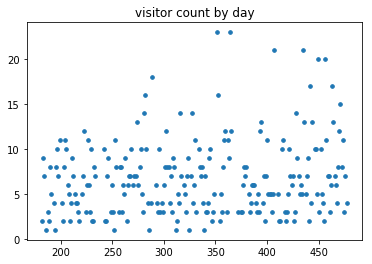

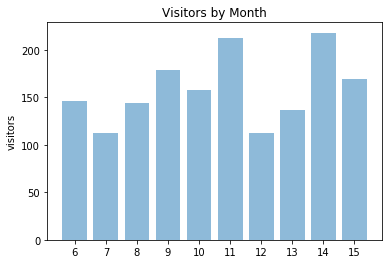

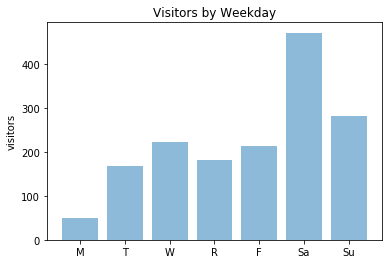

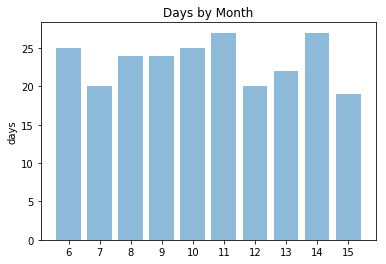

In [100]:
visit_by_store(test_stores[34])

### Given a store, check out the difference of number of visitors between two dates

In [6]:
def diff_by_day(store_id=None, delta=7):
    store_visit = air_visit_hist[air_visit_hist.air_store_id == store_id][['day_ind', 'visitors']]
    store_next_delta = store_visit.copy()
    store_visit['next_delta'] = store_visit['day_ind'] + delta
    store_visit = store_visit.merge(store_next_delta, left_on='next_delta', right_on='day_ind', suffixes=['', '_r'])
    
    store_visit['diff_'+str(delta)] = store_visit['visitors'] - store_visit['visitors_r']
    plt.scatter(store_visit['day_ind'], store_visit['diff_'+str(delta)], s=13)
    plt.title('difference in count by delta=' + str(delta))
    plt.show()
    print(store_visit.describe()['diff_'+str(delta)])

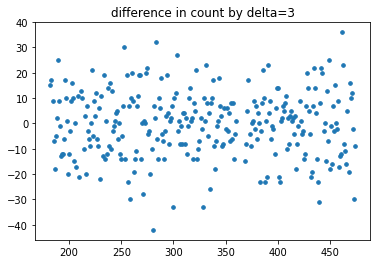

count    283.000000
mean      -0.222615
std       12.974467
min      -42.000000
25%       -9.000000
50%        1.000000
75%        8.500000
max       36.000000
Name: diff_3, dtype: float64


In [10]:
diff_by_day(store_id=test_stores[200], delta=3)

### Explore relation between reserve and total visitors

In [11]:
cols = list(air_visit_hist.columns) + ['reserve_visitors']

air_visit_hist1 = air_visit_hist.merge(air_reserve_day, how='left', left_on=['air_store_id', 'day_ind'], 
                                       right_on=['air_store_id', 'day_ind'], suffixes=['', '_r'])[cols]

cols = cols + ['reserve_visitors_h']

air_visit_hist2 = air_visit_hist1.merge(hpg_reserve_day, how='left', left_on=['hpg_store_id', 'day_ind'],
                                       right_on=['hpg_store_id', 'day_ind'], suffixes=['', '_h'])[cols]

air_visit_hist2.drop('hpg_store_id', axis=1, inplace=True)

air_visit_hist2.fillna(0, inplace=True)

air_visit_hist2['all_reserve_visitors'] = air_visit_hist2['reserve_visitors'] + air_visit_hist2['reserve_visitors_h']

air_visit_hist3 = air_visit_hist2[air_visit_hist2.all_reserve_visitors > 0 ].copy()

air_visit_hist3['non_reserve_visitors'] = air_visit_hist3['visitors'] - air_visit_hist3['all_reserve_visitors']

In [12]:
check = air_visit_hist3[air_visit_hist3.non_reserve_visitors < 0]

In [34]:
with_reserve = air_visit_hist3[air_visit_hist3.all_reserve_visitors > 0][['visitors', 'all_reserve_visitors']]

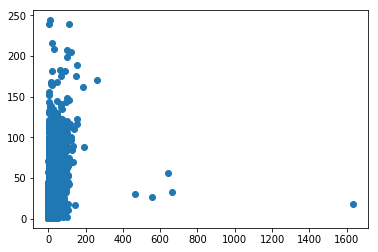

In [37]:
plt.scatter(with_reserve.all_reserve_visitors, with_reserve.visitors)

### Outliers are annoying

In [38]:
with_reserve1 = with_reserve[with_reserve.all_reserve_visitors < 300]

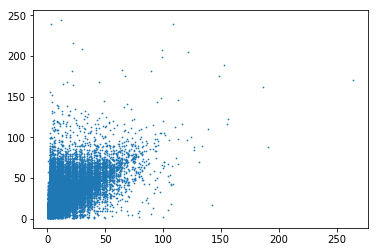

In [41]:
plt.scatter(with_reserve1.all_reserve_visitors, with_reserve1.visitors, s=0.5)

### Explore area and genre

In [54]:
air_store_info.air_area_name.value_counts()

Fukuoka-ken Fukuoka-shi Daimyō                   64
Tōkyō-to Shibuya-ku Shibuya                      58
Tōkyō-to Minato-ku Shibakōen                     51
Tōkyō-to Shinjuku-ku Kabukichō                   39
Tōkyō-to Setagaya-ku Setagaya                    30
Tōkyō-to Chūō-ku Tsukiji                         29
Ōsaka-fu Ōsaka-shi Ōgimachi                      25
Hiroshima-ken Hiroshima-shi Kokutaijimachi       23
Tōkyō-to Meguro-ku Kamimeguro                    22
Tōkyō-to Suginami-ku Asagayaminami               21
Hokkaidō Sapporo-shi Minami 3 Jōnishi            21
Tōkyō-to Chiyoda-ku Kudanminami                  20
Ōsaka-fu Ōsaka-shi Kyūtarōmachi                  19
Hyōgo-ken Kōbe-shi Kumoidōri                     17
Miyagi-ken Sendai-shi Kamisugi                   17
Tōkyō-to Taitō-ku Higashiueno                    16
Fukuoka-ken Fukuoka-shi Hakata Ekimae            16
Tōkyō-to Chūō-ku Ginza                           14
Shizuoka-ken Hamamatsu-shi Motoshirochō          13
Hokkaidō Asa

Note: the number of restaurants in each area greatly varies, the trouble is that we don't know the size and population of each area.

In [55]:
air_store_info.air_genre_name.value_counts()

Izakaya                         197
Cafe/Sweets                     181
Dining bar                      108
Italian/French                  102
Bar/Cocktail                     79
Japanese food                    63
Other                            27
Yakiniku/Korean food             23
Western food                     16
Okonomiyaki/Monja/Teppanyaki     14
Creative cuisine                 13
International cuisine             2
Asian                             2
Karaoke/Party                     2
Name: air_genre_name, dtype: int64